In [23]:
# System imports
import sys
sys.path.append("../")

# Module imports
import numpy as np
import matplotlib.pyplot as plt

# FscoreAI imports
from sample_data import sample_data

# Simple Linear Regression
Assume a dataset $\{\mathbf{X}, \mathbf{y}\}$
$$
	\mathbf{X} = \begin{bmatrix}
	x^{(1)} & \dots & x^{(n)}\\
	\end{bmatrix}
	\text{,}\qquad
	\mathbf{y} = \begin{bmatrix}
	y^{(1)} & \dots & y^{(n)}\\
	\end{bmatrix}
$$
where the discrete or continuous independent variable (also called the input, predictor, or covariate) $\mathbf{X} \in \mathbb{R}^{n}$ and the continuous dependent variable (also called the output, target, label, or response variable) $\mathbf{y} \in \mathbb{R}^{n}$, $n$ is the number of training examples. We wish to use a supervised learning approach for a regression application by learning a model hypothesis $h_\theta\left(\mathbf{x}^{(i)}\right)$ which predicts $\hat y^{(i)}$ given ${x}^{(i)}$, assuming the relationship between the two is linear.

## Data

Let's start by creating a dummy dataset using our pre-built `simulate_linear_data` helper function.

(1000, 1) (1000, 1)


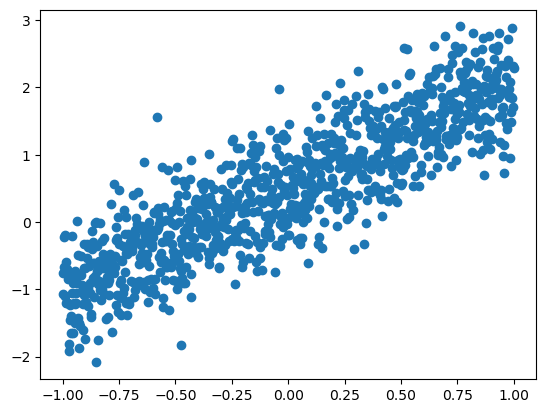

In [24]:
# Create a sample linear data
num_samples = 1000
X, y = sample_data.simulate_linear_data(n=num_samples, beta_0=0.5, beta_1=1.5)
print(X.shape, y.shape)

# Display sample data
plt.scatter(X, y)

## Model
We can see that the data may be a bit noisy, but it is pretty linear in nature. Since we assume that the relationship between the predictor variable and the target variable is linear, we can try finding the best-fit line that, as the name suggests, tries to best describes the trend of the data. This line is also called a regression line. Recall the formula for a line from primary school algebra: 

$$\boxed{h_\theta\left(x^{(i)}\right) = y^{(i)} = \theta_1x^{(i)}+\theta_0}$$

Here, $\theta_0$, also called the bias or the intercept, represents the average output of the model when all $x^{(i)} = 0$ and $\theta_1$, also called the coefficient or slope, represents the average effect of one-unit increase of $x$ on $y$.

Because we created this dataset ourselves, we already know the values of $\theta_0$ and $\theta_1$ in this example. We set them above as $\theta_0 = 0.5$ and $\theta_1 = 1.5$. But for real world, we will have no clue on what these values are. So, let's pretend we are unaware of these parameter values and try to find them mathematically.

Note that the term $\theta_0$ makes the function affine.

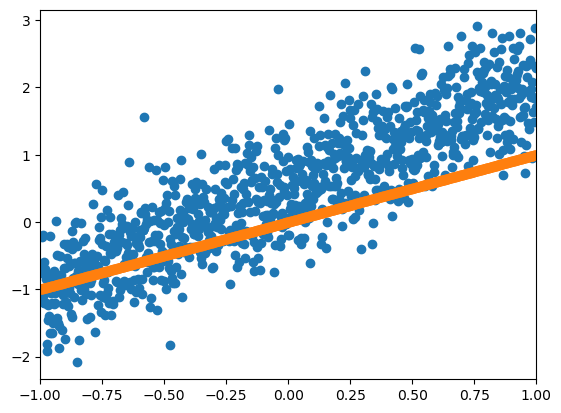

In [25]:
# Default assumptions for the purpose of this example
theta_0 = 0
theta_1 = 1

# Model predictions
y_preds = (theta_1 * X) + theta_0

plt.xlim(-1, 1)
plt.scatter(X, y)
plt.scatter(X, y_preds)

Above we can see that our orange line kind of fits the data, but we can do better. To understand how well our line fits the data, we must figure out a way to mathematically quanitfy the "performance" of our model. To do so, let's talk about Loss Functions.

## Loss Function
In order to quantify how well our model performs, we must define a function that compares the predicted output values $\hat y$ to the actual output values $y$. We will call such a function the "loss" function. One way to define the loss is to calculate the distance between the two values. Let's call this distance the "residual" $r$, where 
$$
r^{(i)} = y^{(i)} - \hat{y}^{(i)}
$$
We would like each training example's residual to be as close to zero as possible.

In [26]:
residuals = (y - y_preds)
residuals[:5]

array([[ 0.24835708],
       [-0.06813115],
       [ 0.32584627],
       [ 0.76451793],
       [-0.11307268]])

To quantify how well our model as a whole performs, let's find the average residuals over all our training examples. We shall call this function our "cost" function and it is the mean of the absolute values of our residuals. This method is called, you guessed it, Mean Absolute Error (MAE). The caveat with using MAE is that absolute values are non-differentiable functions, which are not desirable for taking derivatives (which we would eventually need to take for training this model using gradient descent). 

Instead, we can choose to average the sum of squared residuals. This will keep the function differentiable, with an added benefit of penalizing larger losses over smaller ones. This function is also called Mean Squared Error (MSE) and is as follows:
$$
	\boxed{\mathcal{E} = \frac{1}{n}\sum_{i=1}^n{r^{(i)}}^2}
$$
Note: Dividing the sum of squared residuals by $n$ gives us a biased estimate of the variance of the unobserved errors. To remove the bias, divide the sum of squared residuals by $\mathrm{df} = n - d - 1$ where $\mathrm{df}$ is the degrees of freedom, and $d$ is the number of parameters being estimated (excluding the intercept). You will understand this more when we talk about multiple linear regression.

In [27]:
# MSE Loss
def MSELoss(y, y_preds):
    residuals = (y - y_preds)**2
    return np.sum(residuals) / num_samples

print(MSELoss(y, y_preds))

0.5927712565390625


## Training
Now that we are able to figure out how well our model as a whole performs, we would like to avoid "guesstimating" the $\theta$ parameters and actually calculate them mathematically. There are multiple ways to find the optimal $\theta$ values that lead us to the least amount of loss. Let's look at these one at a time. 

### Closed-form/Direct Solution
> Recall from single variable calculus that (assuming a function is differentiable) the minimum $x^*$ of a function $f$ has the property that the derivative $\frac{\mathrm{d}f}{\mathrm{d}x}$ is zero at $x = x^*$. Note that the converse is not true: if $\frac{\mathrm{d}f}{\mathrm{d}x} = 0$, then $x^*$ might be a maximum or an inflection point, rather than a minimum. But the minimum can only occur at points that have derivative zero. We will use this information to find the parameters that minimize our cost in the case of a simple/univariate data distributions. 

To find the optimal $\theta$ values (let's call them $\hat\theta_0$ and $\hat\theta_1$) that lead to the minimum loss, let's take the partial derivative of the cost function with respect to the parameters $\theta_0$ and $\theta_1$. We can then set the derivatives equal to zero, and solve for our estimated parameters.

**Taking the partial derivative w.r.t. $\hat\theta_0$**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_0}}&=\frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left[y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right]^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\left(\sum_{i=1}^ny^{(i)} - n\hat\theta_0-\hat\theta_1\sum_{i=1}^nx^{(i)}\right)
    \\
    & = -2\left(\frac{n}{n}\hat\theta_0+\hat\theta_1\frac{1}{n}\sum_{i=1}^nx^{(i)}-\frac{1}{n}\sum_{i=1}^ny^{(i)}\right)
    \\
    & = -2\left(\hat\theta_0+\hat\theta_1\bar x-\bar y\right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_0$:**
\begin{align*}
	-2\left[\hat\theta_0+\hat\theta_1\bar x-\bar y\right] &= 0
    \\
    \hat\theta_0 &= \bar{y} - \hat\theta_1\bar{x}                      
\end{align*}

**Taking the partial derivative w.r.t. $\hat\theta_1$:**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_1}} &= \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right)^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n (x^{(i)})\left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(x^{(i)}y^{(i)} - (\bar{y} - \hat\theta_1\bar{x}) x^{(i)}- \hat\theta_1 {x^{(i)}}^2\right)
    \\
    & = \frac{-2}{n}\left( \sum_{i=1}^n x^{(i)}y^{(i)} - \bar{y}\sum_{i=1}^nx^{(i)} + \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)}- \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_1$:**
\begin{align*}
    \left( -\sum_{i=1}^n x^{(i)}y^{(i)} + \bar{y}\sum_{i=1}^nx^{(i)} - \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)} +  \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right) &= 0
\end{align*}
\begin{align*}
    \hat\theta_1 \left(\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2\right) &= \bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}
    \\
    \hat\theta_1 &= \frac{\bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}}{\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{n\bar{y} \bar x - \sum_{i=1}^nx^{(i)}y^{(i)}}{n\bar{x}^2-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x}{\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2}
\end{align*}

**To simplify:**
\begin{align*}
\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x &= \sum_{i=1}^n(x^{(i)}-\bar x)(y^{(i)} - \bar{y}) := \mathrm{S_{XY}}
    \\
	\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2 & = \sum_{i=1}^n(x^{(i)} - \bar{x})^2 := \mathrm{S_{XX}}
\end{align*}

$$\boxed{\hat\theta_1 = \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}}$$

$$\boxed{\hat\theta_0 = \bar y - \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}\bar x}$$

The above two equations give us a method to analytically solve for the $\theta$ parameters that will give us the least amount of MSE Loss, thus giving us all the tools we need to find the best-fit line. Let's wrap the above in a `LinearRegression` class that we can improve and expand on. 

In [28]:
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        X_mean = np.sum(X) / num_samples
        y_mean = np.sum(y) / num_samples
        S_XY = 0
        S_XX = 0
        for sample in range(num_samples):
            S_XY += (X[sample] - X_mean) * (y[sample] - y_mean)
            S_XX += (X[sample] - X_mean)**2
        self.intercept_ = y_mean - (S_XY / S_XX * X_mean)
        self.coef_ = S_XY / S_XX
    
    def predict(self, X):
        num_samples = X.shape[0]
        preds = []
        for sample in range(num_samples):
            y_preds = self.coef_ * X[sample]
            preds.append(y_preds + self.intercept_)
        return np.array(preds).reshape(-1, 1)

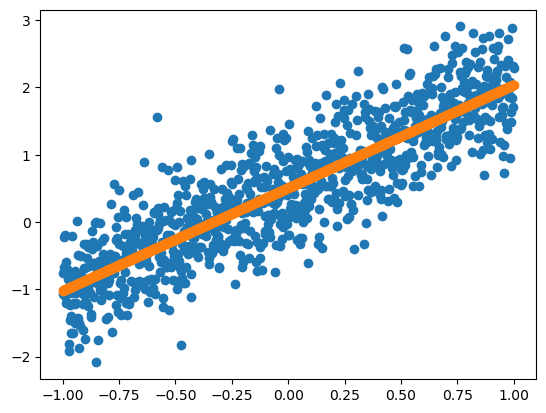

In [29]:
model = LinearRegression()
model.fit(X, y)
y_preds = model.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_preds)

Now, let's compare our MSE loss with the one we got previously:

In [30]:
print(MSELoss(y, y_preds))

0.23917472439094223


You can see our latest loss is much lower than the one we calculated previously. We can say that this model performs better than the one before.

Now that we can find the best-fit line in the case of univariate data, let's try to up the game by finding the best fit "plane" for multivariate data.

# Multivariate Linear Regression
We can represent multivariate data using the following matrices:
$$
	\mathbf{X} = \begin{bmatrix}
	x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
	\text{,}\qquad
	\mathbf{Y} = \begin{bmatrix}
	y^{(1)}\\
	\vdots\\
	y^{(n)}
	\end{bmatrix}
$$
where the input $\mathbf{X} \in \mathbb{R}^{n\times d}$ and the output $\mathbf{Y} \in \mathbb{R}^{n\times 1}$. Here, $d$ is the number of features and like before, $n$ is the number of training examples.

## Data
We can now use our `simulate_multilinear_data` function to create a training dataset with mutliple features. 

(1000, 2) (1000, 1)


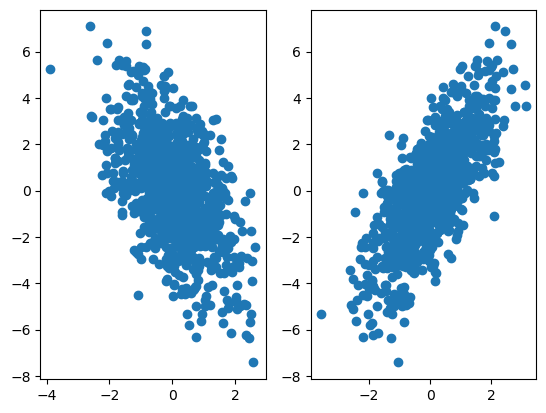

In [31]:
# Create a sample linear data for demonstration purposes
num_samples = 1000
num_features = 2
X, y = sample_data.simulate_multilinear_data(n=num_samples, d=num_features, seed=1234)
print(X.shape, y.shape)

# Display sample data
fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y)
ax[1].scatter(X[:,1], y)

## Model
Since the relationship between the input and the output is linear, we can use the following function to describe the model for the $i$-th example:
$$
	\boxed{h_\theta(\mathbf{x}^{(i)}) = \theta_0 + \theta_1 x^{(i)}_{1} + \dots + \theta_d x^{(i)}_{d} = \theta_0 + \sum_{j=1}^d\theta_j  x^{(i)}_{j}}
$$
where $i = (1,\dots,n)$, $j = (1,\dots,d)$, $\theta_0$ is the bias and $\theta_j$ representst the coefficient of a specific feature $d$. 

Now, let's update the `predict` function in our previously created `LinearRegression` class to accomodate predictions on multivariate data. 

In [32]:
class LinearRegression():
    def __init__(self):
        self.coef_ = np.array([1, 1])
        self.intercept_ = 0
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        X_mean = np.sum(X) / num_samples
        y_mean = np.sum(y) / num_samples
        S_XY = 0
        S_XX = 0
        for sample in range(num_samples):
            S_XY += (X[sample] - X_mean) * (y[sample] - y_mean)
            S_XX += (X[sample] - X_mean)**2
        self.intercept_ = y_mean - (S_XY / S_XX * X_mean)
        self.coef_ = S_XY / S_XX
    
    # UPDATED
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

MSE: 5.94767241086877


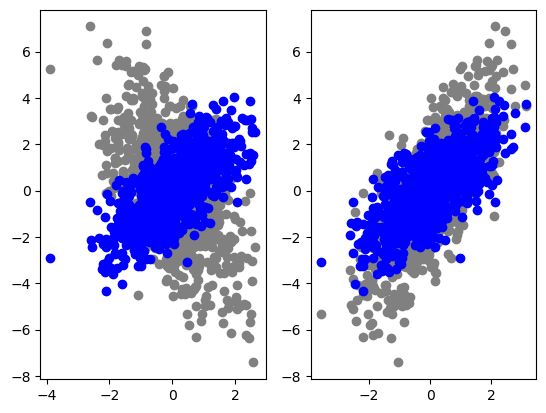

In [33]:
# Testing out or model with default theta parameters and calcluating the loss
model = LinearRegression()
y_preds = model.predict(X)

fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

print("MSE:",MSELoss(y, y_preds))

## Training
Now that we have a way to predict on multivariate data, along with a way to evaluate its performance, we need to figure out a way to optimize our $\theta$ parameters using a similar analytical, closed-form, approach. Note: Most machine learning algorithms do not have analytical solutions; linear regression used in this manner is a unique case.

Soon we will also take a look at optimizing our parameters using more general approaches like Gradient Descent and Maximum Likelihood Estimation.

### Closed-form/Direct Solution
To find a closed-form solution to multivariate linear regression, let's use a vectorized approach. We will first need to augment our design matrix to incorporate the bias term in $\mathbf{X}$. This notational "trick" helps us rewrite our matrix as:
$$
	\mathbf{X} = \begin{bmatrix}
	1 & x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	1 & x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
    \qquad
    \mathbf{Y} = \begin{bmatrix}
	y^{(1)}\\
	\vdots\\
	y^{(n)}
	\end{bmatrix}
    \qquad
    \theta = \begin{bmatrix}
	\theta_0 & \dots & \theta_{d}\\
	\end{bmatrix}
$$
where $\mathbf{X} \in \mathbb{R}^{n\times (d+1)}$ and $\theta \in \mathbb{R}^{d+1}$. Notice that we have added a column of 1's in $\mathbf{X}$.

Now we can revisit our hypothesis function which can be rewritten as follows:
$$h_\theta\left(x^{(i)}\right) = \sum_{j=0}^d\theta_j x_j^{(i)}$$

Or, in matrix form: 
$$h_\theta(\mathbf{x}) = \mathbf{X}\theta$$

Our cost function can be rewritten as follows:
\begin{align*}
\mathcal{E}(\theta) &= \frac{1}{n}\sum_{i=1}^n({h_\theta(x^{(i)}) - y^{(i)}})^2
\\
&= \frac{1}{n}\sum_{i=1}^n({y_i - \mathbf{x}_i\theta})^2
\\
&= \frac{1}{n}(\theta^\top x^{(i)} - y^{(i)})^2
\\
&= \frac{1}{n}(\mathbf{X}\theta - y)^\top (\mathbf{X}\theta - y)
\\
&= \frac{1}{n}(\mathbf{X}\theta - y)^\top(X\theta - y)
\\
&\propto \theta^\top X^\top X\theta - y^\top X\theta - \theta^\top X^\top y + y^\top y
\\
&\propto \theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y
\end{align*}

Like before, let's take the partial derivative of the loss function with respect to $\theta$ and set it equal to zero to find the values where loss is minimum.
\begin{align}
\frac{\delta}{\delta\theta}(\theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y) &= 0
\\
(X^\top X)\theta - X^\top y &= 0
\\
(X^\top X)\theta &= X^\top y
\\
\theta &= (X^\top X)^{-1}X^\top y
\end{align}

If $X^\top X$ is not invertible, you can use pseudo-inverse instead of the inverse by using `numpy.linalg.pinv(a)`. Also, make sure to remove redundant (non-linearly dependent) features, and maintain $d \le n$. Now, let's incorporate the above in our `LinearRegression` class.

In [34]:
# Vectorized
class LinearRegression():
    def __init__(self):
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
        
    # UPDATED
    def fit(self, X, y):
        n, d = X.shape
        X = np.hstack((np.ones((n, 1)), X))
        self.weights_ = np.linalg.inv(X.T@X) @ (X.T@y)
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
        return
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

MSE: 0.9801592173253427


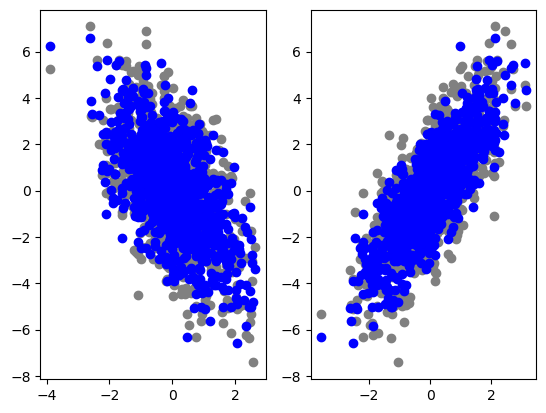

In [35]:
model = LinearRegression()
model.fit(X, y)
y_preds = model.predict(X)


fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

print("MSE:",MSELoss(y, y_preds))

We can see above that our model is able to fit the data quite well.

### Optimization Using Gradient Descent
Now that we have seen some evaluation techniques, let's return to techniques for optimizing our $\theta$ parameters. The most common technique for optimization is called gradient descent. It is an iterative optimization algorithm used to update the $\theta$ coefficients to minimize the cost function $\mathcal{E}$. The basic algorithm works as follows:
1. Initialize all $\theta_j$ to some default values (often set to 0 or small random values).
2. Repeat until convergence:
    1. Calculate the gradient (or derivative) of the cost function with respect to each coefficient.
    2. Update each coefficient using the following rule:
        $$\theta_j \leftarrow \theta_j - \alpha \frac{\delta}{\delta\theta_j}\mathcal{E}(\theta)$$
        where $\alpha$ is an empirically-set learning rate. The above updates $\theta_j$ toward the direction of steepest descent.
    3. Continue this process until the cost function converges to a minimum, or a predefined number of iterations is reached.

Let's look a bit deeper into the update rule for gradient descent. For simplicity, let's continue to incorporate the bias term along with the coefficients. Now, for each $j$, where $j = (0,\dots,d)$:
\begin{aligned}
    \frac{\delta\mathcal{E}}{\delta\theta} & = \frac{\delta}{\delta\theta}\frac{1}{n}\sum_{i=1}^n \left(\hat y^{(i)} - y^{(i)}\right)^2
    \\
    & = \frac{2}{n}\sum_{i=1}^n (\hat y^{(i)} - y^{(i)}) \frac{\delta}{\delta \theta_j}(\theta x^{(i)} - y^{(i)})
    \\
    & = \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
\end{aligned}
Our update rule thus looks like the following:
$$
	\theta_j \leftarrow \theta_j - \alpha \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
$$

The above equation is also called batch gradient descent. "Batch" because all training examples are summed at every step. A disadvantage of this technique is that it is very computationally inefficient, especially for large datasets. To make gradient descent more optimized, we can alternatively use Stochastic Gradient Descent (SGD), which is noisy but eventually leads to the similar results as batch gradient descent. SGD takes the derivative of one example at a time. The gradient takes a bit more noisy approach toward the minima and it never truly "converges".

The difference between Batch Gradient Descent and Stochastic Gradient Descent mainly lies in how the model's parameters are updated:
1. **Batch Gradient Descent**:
   - In Batch Gradient Descent, the entire training dataset is used to compute the gradient of the cost function at each iteration.
   - The algorithm calculates the average gradient over the entire dataset and updates the model's parameters in a single step.
   - This method tends to be stable and deterministic, but it can be computationally expensive for large datasets since it requires processing the entire dataset in each iteration.
   - The updates are more accurate since they consider a comprehensive view of the dataset.

2. **Stochastic Gradient Descent (SGD)**:
   - In Stochastic Gradient Descent, a single training example or a small subset (mini-batch) of the training data is used to compute the gradient at each iteration.
   - The algorithm performs more frequent updates to the model's parameters, often resulting in faster convergence.
   - Since each update is based on a single example or a small subset, the updates can be noisy and the optimization process may exhibit more variability.
   - Stochastic Gradient Descent can be more efficient for large datasets since it doesn't require processing the entire dataset in each iteration.

3. **Mini-Batch Gradient Descent**:
   - Mini-Batch Gradient Descent is a compromise between Batch and Stochastic Gradient Descent.
   - It uses a small randomly selected subset (mini-batch) of the training data to compute the gradient and update the model's parameters.
   - This approach combines some of the advantages of both Batch and Stochastic Gradient Descent: it's computationally efficient and also benefits from some level of noise that can help escape local minima.
   - Mini-batch size is a hyperparameter that can be tuned to achieve a balance between computation efficiency and optimization stability.

We can vectorize our update equations through the following steps. Given that our cost function in matrix-form is:
$$
\mathcal{E}(\theta) = \frac{1}{2n}(y - X\theta)^T(y - X\theta)
$$
To minimize the cost function using gradient descent, will use the following equation:
$$
\theta = \theta - \alpha \nabla \mathcal{E}(\theta)
$$

Where \alpha is the learning rate and $\nabla \mathcal{E}(\theta)$ is the gradient of $\mathcal{E}(\theta)$ with respect to $\theta$. Let's compute $\nabla \mathcal{E}(\theta)$ step by step:
|
\begin{align*}
\mathcal{E}(\theta) & = \frac{1}{2n}(y - X\theta)^T(y - X\theta) \\
& = \frac{1}{2n}(y^Ty - 2\theta^TX^Ty + \theta^TX^TX\theta)
\end{align*}

Now, let's calculate the gradient:

\begin{align*}
\nabla \mathcal{E}(\theta) & = \nabla \left(\frac{1}{2n}(y^Ty - 2\theta^TX^Ty + \theta^TX^TX\theta)\right) \\
& = \frac{1}{2n}\nabla (y^Ty) - \frac{1}{2n}\nabla (2\theta^TX^Ty) + \frac{1}{2n}\nabla (\theta^TX^TX\theta)
\end{align*}

Since \(y^Ty\) is a constant with respect to $\theta$, its gradient is zero. Next, let's calculate the gradient of $-2\theta^TX^Ty$:
$$
\nabla (-2\theta^TX^Ty) = -2X^Ty
$$
Now, let's calculate the gradient of $\theta^TX^TX\theta$:
\begin{align*}
\nabla (\theta^TX^TX\theta) & = \nabla (\theta^T(X^TX)\theta) \\
& = (X^TX)\theta + (X^TX)^T\theta \\
& = 2X^TX\theta
\end{align*}

Putting it all together:
\begin{align*}
\nabla \mathcal{E}(\theta) & = \frac{1}{2n}(-2X^Ty + 2X^TX\theta) \\
& = \frac{1}{n}(X^TX\theta - X^Ty)
\end{align*}

Finally, we can update $\theta$ using gradient descent:
$$
\theta = \theta - \alpha \nabla \mathcal{E}(\theta) = \theta - \frac{\alpha}{n}(X^TX\theta - X^Ty)
$$

In [36]:
# Gradient Descent Implementation
class LinearRegression():
    def __init__(self):
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y, lr, epochs):
        n, d = X.shape
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights_ = np.random.randn(d+1, 1)
        for epoch in range(epochs):
            y_pred = X.dot(self.weights_)
#             dw = (1 / n) * np.dot(X.T, (y_pred - y))
            dw = (1/n)*(np.dot(X.T,np.dot(X,self.weights_)) - np.dot(X.T, y))
            self.weights_ = self.weights_ - (lr * dw)
            
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.dot(X, self.weights_)
        return y_pred

MSE: 0.9801592510602084


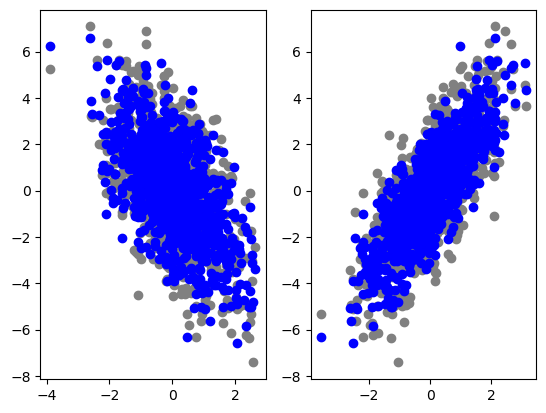

In [37]:
model = LinearRegression()
model.fit(X, y, 1e-3, 10000)
y_preds = model.predict(X)

fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

print("MSE:",MSELoss(y, y_preds))

## Probabilistic Interpretation of Linear Regression
An alternative view of finding the optimized parameters is to think about the probabilistic method that might have generated our data (as a conditional probability distribution). This procedure must have had some parameters that we could estimate to try and re-generate the data.

Let's say we are given a dataset $\{\mathbf{x}_n, y_n\}_{n=1}^N$ where $x_n \in \mathbb{R}^D$ is the independent variable while $y_n \in \mathbb{R}$ is a dependent variable. We will assume that the data-generating process looked like this: 

$$
y=\mathbf{x}^\top \mathbf{w}+\epsilon
$$

where $\epsilon \in \mathbb{R}$ is a random variable capturing the noise. There can be multiple noise models for $\epsilon$, but for generalizaiton, let's assume $\epsilon$ is from a zero-mean Gaussian distrubtion of variance $\sigma^2$: 
$$\epsilon|\sigma^2 \sim \mathcal{N}(\epsilon|0,\sigma^2)$$

We will also assume that $y_n$ follows a normal distribution over all $\mathbf{x}_n$ defined by an independent and fixed standard deviation $\sigma$, and a dependent and variable set of parameters $\theta$. 

Thus, using the probability density function of an univatiate Gaussian, we can say: 

$$
\text{Pr}(y_n|\mathbf{x}_n, \mathbf{w}, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left\{\frac{-1}{2\sigma^2}(y_n - \mathbf{x}_n^\top \mathbf{w})^2\right\}
$$

Since we have $N$ independent and indentically distributed (i.i.d.) samples, and we will also assume that the $n$th observation $\epsilon_n$ is also i.i.d., we can write our overall likelihood function as a product over these $N$ terms:

$$
\text{Pr}(\{y_n\}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}, \sigma^2) = \prod_{n=1}^{N}\frac{1}{\sigma\sqrt{2\pi}}\exp\left\{\frac{-1}{2\sigma^2}(y_n - \mathbf{x}_n^\top \mathbf{w})^2\right\}
$$

This equation is also called the likelihood.

We are interested in producing a model that, instead of estimating a single value $\hat y$, it estimates a conditional distribution.  $p(y|\mathbf{x})$. More specifically, we would like to find the parameters $\theta^*$ that give us the highest probability to the observed data.

We can do so through the following: 
$$
\theta^* = \arg\max_\theta \text{Pr}(\{y_n\}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}, \sigma^2)
$$

In practive, we would like to maximize sums rather than products, so we can take the $\log$ of the above and maximize log-likelihood instead. Note: taking the $\log$ does not shift the location of the maxima. 

After finding the negative loss function, we can do the same as we did before: differentiate, set to zero, and solve for $\theta^*$

Before we continue, let's vectorize our data to a similar notational "trick" design matrix we used before, and convert our univariate Gaussian to a multivariate Gaussian with a diagonal covariance matrix. 

> Recall: the PDF for a $D$-dimensional Gaussian is: $$\text{Pr}(z|\mu,\Sigma) = |\Sigma|^{-1/2}(2\pi)^{-D/2}\exp\left\{\frac{-1}{2}(z-\mu)^\top\Sigma^{-1}(z-\mu)\right\}$$ The covariance matrix $\Sigma$ must be square, symmetrical, and positive definite. When $\Sigma$ is diagonal, the $D$ dimensions are independent of each other. 

So, the PDF for our regression looks like the following: 
$$
\text{Pr}(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma^2\mathbf{I}) = (2\sigma^2\pi)^{-N/2}\exp\left\{-\frac{1}{2\sigma^2}(\mathbf{X}\mathbf{w}-\mathbf{y})^\top(\mathbf{X}\mathbf{w}-\mathbf{y})\right\}
$$

We can now take the natural log as discussed before: 
$$
\log\text{Pr}(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2) = -\frac{N}{2}\log(2\sigma^2\pi) -\frac{1}{2\sigma^2}(\mathbf{X}\mathbf{w}-\mathbf{y})^\top(\mathbf{X}\mathbf{w}-\mathbf{y})
$$

We can ignore the additive term since it does not have a $\mathbf{w}$, then we are left with: 

$$
\theta^* = \arg\max_\theta \left\{-\frac{1}{2\sigma^2}(\mathbf{X}\mathbf{w}-\mathbf{y})^\top(\mathbf{X}\mathbf{w}-\mathbf{y})\right\}
$$

The $\frac{1}{2\sigma^2}$ term does not affect our solution so we can ignore this too, although it does affect our sign and could change it from maximization to minimzation. So, 
$$
\boxed{\theta^* = \arg\min_\theta (\mathbf{X}\mathbf{w}-\mathbf{y})^\top(\mathbf{X}\mathbf{w}-\mathbf{y})}
$$

We have arrived at the exact solution we got for our least-squares linear regression. This reveals that underneath, they are doing the same thing. Least squares is also assuming Gaussian noise!

### Bayesian Interpretation (Working Draft) 
Given  $\hat{y} = w^{\mathsf{T}}x$ over a training set $\{X^\mathrm{train}, y^\mathrm{train}\}$ of $n$ examples, we can express a Gaussian distribution on $y$, we have $$\begin{aligned} 
p(y|X, w) &= \mathcal{N}(y;Xw, I) \\&
\propto \exp \left(-\frac{1}{2} (y-Xw)^\mathsf{T} (y-Xw)\right)
\end{aligned}$$, where we assume the standard MSE formulation assuming that the Gaussian variance $y$ is one. To determine the posterior distribution over the model parameter vector $w$, we first need to specify a prior distribution. The prior should reflect our naive belief about the values of these parameters. It is common to use the Gaussian as our prior $$p(w) = \mathcal{N}(w;\mu_0,\Lambda_0) \propto \exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right)$$where,
- $\mu_0$ is the prior distribution mean vector
- $\Lambda_0$ is the prior distribution covariance matrix

We can now define the posterior distribution over the model parameters 
$$\begin{aligned}
p(w|X,y) &\propto p(y|X,w)p(w) \\
&\propto \exp\left(-\frac{1}{2}(y-Xw)^\mathsf{T}(y-Xw)\right)\exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(-2y^\mathsf{T}Xw+w^\mathsf{T}X^\mathsf{T}Xw+w^\mathsf{T}\Lambda_0^{-1}w-2\mu_0^\mathsf{T}\Lambda_0^{-1}w\right)\right) \\
\end{aligned}$$
Now, we define $\Lambda_n = (X^\mathsf{T}X+\Lambda_0^{-1})^{-1}$ and $\mu_m = \Lambda_m(X^\mathsf{T}y+\Lambda_0^{-1}\mu_0)$. Using these new variables, we find that the posterior may be rewritten as a Gaussian distribution: 
$$
\begin{aligned}
	p(w|X,y) & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)+\frac{1}{2}\mu_n^\mathsf{T}\Lambda_n^{-1}\mu_n\right) \\
	         & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)\right)                                                
\end{aligned}
$$
All terms that do not include the parameter $w$ have been omitted; they are implied by the fact that the distribution must be normalized to integrate to 1. 

Examining this posterior distribution gives us some intuition for the effect of Bayesian inference. In most cases, we set $\mu_0 = 0$. if we set $\Lambda_0 = \frac{1}{\alpha}I$, then $\mu_n$ gives the same estimate of $w$ as does frequentist linear regression with a weight decay penalty of $\alpha w^\mathsf{T}w$. One difference is that the Bayesian estimate is undefined if $\alpha=0$, we are not allowed to begin the Bayesian with an infintely wide prior to $w$. The more important difference is that the Bayesian estimate provides us a covariance matrix, showing how likely all the different values of $w$ are, rather than only the estimate $w_n$. 

# Evaluation
We can see this value is much lower than the one we previously predicted. MSE Loss is a good way to compare models, but it is highly context-specific and does not translate well to the real world. We would like to find better ways to understand the fit of our model. Let's take a step aside and look into some evaluation techniques that will help us better understand our model performance.

### Residuals Plot
Residual vs. predicted value plots help us find the bias in our model. We usually employ this model before any other evaluation to make sure our data is "fit" for a linear regression model. Some datasets are just not good candidates for regression. Their properties include:
- Heteroscedastic data (points at widely varying distances from the line).
- Data that is non-linearly associated.
- Data sets with outliers.

These problems are more easily seen with a residual plots than by looking at a plot of the original data set. Ideally, residual values should be equally and randomly spaced around the horizontal axis.

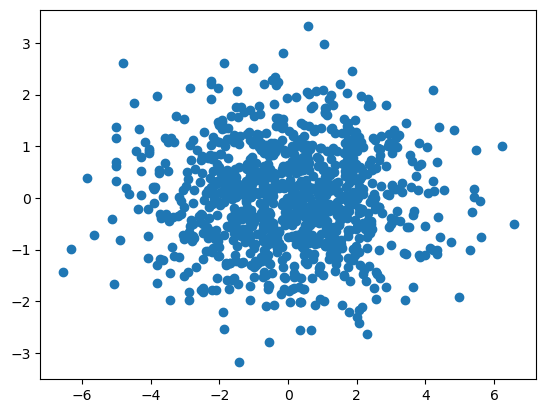

In [38]:
# Residual Plot
residuals = y_preds - y
plt.scatter(y_preds, residuals)

### Coefficient of Determination ($R^2$)
The coefficient of determination, denoted $R^2$ or $r^2$ and pronounced "R squared", is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). The coefficient of determination is a number between 0 and 1 that measures how well a statistical model predicts an outcome. $R^2$ helps us find the measure of a good fit compared to the measure of a bad fit.

It is calculated using the following formula:
$$R^2 = 1 - \frac{RSS}{TSS}$$

$RSS$ os the sum of squared residuals while $TSS$ is the total sum of squares. This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable. 

In [39]:
def r_squared(true, predicted):
    true = np.squeeze(true)
    predicted = np.squeeze(predicted)

    assert true.ndim == 1
    assert predicted.ndim == 1

    n = true.shape[0]
    true_mean = np.sum(true, axis=0)/n
    
    SSR = np.sum((true - predicted)**2)
    SSM = np.sum((true - true_mean)**2)    
    
    return 1 - (SSR / SSM)

In [40]:
r_squared(y, y_preds)

0.8055498849540953

## Criteria and Assumptions
- Linearity: The model assumes that there is a linear relationship between the independent and the dependent variables. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by transforming one or more independent variables, the dependent variable, or both. In other cases, a generalized linear model or a nonlinear model may be warranted.
- Weak exogeneity: This essentially means the predictor variables $X$ can be treated as fixed values, rather than random variables.
- Constant variance/homoscedasticity: This means that the variance of the errors does not depend on the values of the predictor variables. Thus the variability of the responses for given fixed values of the predictors is the same regardless of how large or small the responses are. The standard deviation of the dependent variable $Y$ should be constant for different values of $X$. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), robust standard errors, or variance stabilizing transformations.
- Independence of errors: This assumes that the errors of the response variables are uncorrelated with each other. e.g. Observations across time may be correlated
- Normal distribution for errors.  The $\epsilon$ term is assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot. $\epsilon_i \sim N(0, \sigma^2)$. Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively.
- Correlated Predictors: Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using [[Regularization]], or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis PCA.
- Influential Points: Data points that have undue influence on the regression model can be high leverage points or outliers. Such points are typically removed and the regression model rerun.

## Applications
Linear Regression has plenty of applications in the real world. Some of these include:
- Trend line estimation in time-series data
- Predicting crop yields based on rainfall
- Revenue forecasting
- Blood pressure increase based on drug dosage

## Advantages
- Easy and fast to train
- Works with big and small datasets (provided number of data points is greater than number of features)
- Transparent predictions
- In case of multiple independent variables, we can go with forward selection, backward elimination and step wise approach for selection of most significant independent variables.

## Disadvantages
- Multiple regression suffers from multicollinearity, autocorrelation, heteroskedasticity
- Linear Regression is very sensitive to Outliers. It can terribly affect the regression line and eventually the forecasted values.
- Multicollinearity can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable.

# Polynomial Regression
A regression equation is a polynomial regression equation if the power of independent variable is more than 1. The equation below represents a polynomial model: $\hat{y}=b+\sum_{i=1}^9\beta_ix^i$ where the model is a polynomial of degree 9. This is a generalized case for the linear regression model. 

> Polynomial is still linear! Note that even though these models implement a polynomial function of its inputs, the output is still a linear function of the parameters, so we can still use the normal equations to train the model in closed form. These models increase the capacity of the model.

While there might be a temptation to fit a higher degree polynomial to get lower error, this can result in overfitting. Always plot the relationships to see the fit and focus on making sure that the curve fits the nature of the problem. Here is an example of how plotting can help. Especially look out for curve towards the ends and see whether those shapes and trends make sense. Higher polynomials can end up producing weird results on extrapolation.


# Regularization
Regularization helps control the model complexity by penalizing large values of $\theta$. By incorporating a regularization term $\lambda$ into the cost function, we can reduce the complexity, consequently reducing overfitting of our models. There are two main ways to add regularization to our models: L1 and L2 regularizations.

## Ridge Regression (L1)
Ridge regression performs L2 regularization, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. It is a technique used when the data suffers from multicollinearity (independent variables are highly correlated). It is mainly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high number of features, say in millions, as it will pose computational challenges. It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation. It includes all (or none) of the features in the model. Thus, the major advantage of ridge regression is coefficient shrinkage and reducing model complexity. Ridge regression shrinks the value of coefficients but doesn’t reaches zero, which suggests no feature selection feature

$$\begin{aligned}&
\min_\theta \mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of squares of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d \theta_j^2 \\&
\text{Gradient: } \frac{\delta\mathcal{L}}{\delta{\theta}_j} = -2\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right)+2\lambda\theta_j \\&
\text{Regularization: } \theta_j^{t+1} = \theta_j^t - \eta\left[-2\sum_{i=1}^nx_{ij}\left(y_i-\sum_{k=0}^m\theta_kx_{ik}\right)+2\lambda\theta_j\right] \\&
= (1-2\lambda\eta)\theta_j^t + 2\eta \sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \\&
\text{Note: }\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \text{ is the same as simple linear regression}
\end{aligned}$$

The above is equivalent to reducing the weight by a factor of $(1-2\lambda\eta)$ first then applying the same update rule as simple linear regression. This makes coefficients reduce to small numbers but never $0$.

With ridge regression (ridge regularization), our loss function is $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n a_i^2}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning, and it balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. $\alpha$ controls model complexity, 
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of α will decide the weightage given to different parts of objective.

In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

`y=a+b*x+e (error term),  [error term is the value needed to correct for a prediction error between the observed and predicted value]`
`y = a+y = a + b1x1 + b2x2+....+e, for multiple independent variables.`

In a linear equation, prediction errors can be decomposed into two sub components. First is due to the **biased** and second is due to the **variance**. Prediction error can occur due to any one of these two or both components.

Ridge regression solves the multicollinearity problem through shrinkage parameter λ (lambda). Look at the equation below.
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$

In this equation, we have two components. First one is least square term and other one is lambda of the summation of β2 (theta- square) where β is the coefficient. This is added to least square term in order to shrink the parameter to have a very low variance.


## Lasso Regression
Lasso regression performs L1 regularization, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. LASSO stands for _Least Absolute Shrinkage and Selection Operator_. It is helpful in showing us the most important features by reducing non-significant features to 0. Along with shrinking coefficients, lasso performs feature selection as well. Some of the coefficients become exactly zero, which is equivalent to the particular feature being excluded from the model.

Since it provides _sparse solutions_, it is generally the model of choice (or some variant of this concept) for modelling cases where the number of features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.

It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.

Lasso Regression shrinks coefficients to zero (exactly zero), which certainly helps in feature selection. Lasso is a regularization method and uses l1 regularization. If group of predictors are highly correlated, lasso picks only one of them and shrinks the others to zero

$$\begin{aligned}&
\min_\theta\mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of absolute value of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d |\theta_j| \\&
\end{aligned}$$
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$

In this case, the gradient is not defined since absolute function is not differentiable at $x=0$. Use **coordinate descent** instead:
$$\theta_j = 
\begin{Bmatrix}
{g(\theta_{-j})+\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\lt\frac{\lambda}{2}}\\
{0}
{\text{, if }g(\theta_{-j})\le\frac{\lambda}{2}} \\
{g(\theta_{-j})-\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\gt\frac{\lambda}{2}}
\end{Bmatrix}$$
where,
- $\theta_{-j}$ is the difference between predicted and actual outcome considering all *but* the $j^{th}$ variable. If this value is small, it means algorithm is able to predict outcome well even without $j^{th}$ variable, thus it can be removed from the equation by setting a zero coefficient.

With lasso regression (lasso regularization), our loss function = $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n |a_i|}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of $\alpha$ will decide the weightage given to different parts of objective.
- $\alpha = 1$ gives us a baseline model. This phenomenon of most of the coefficients being zero is called ‘**sparsity**‘.

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.  Look at the equation below: Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function, instead of squares. This leads to penalizing (or equivalently constraining the sum of the absolute values of the estimates) values which causes some of the parameter estimates to turn out exactly zero. Larger the penalty applied, further the estimates get shrunk towards absolute zero. This results to variable selection out of given n variables.

## ElasticNet Regression (Hybrid)
ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both. A practical advantage of trading-off between Lasso and Ridge is that, it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

$$\hat\beta = \arg\min_{\beta}(||y-X\beta||^2+\lambda_2||\beta||^2+\lambda_1||\beta||_1)$$


It encourages group effect in case of highly correlated variables. There are no limitations on the number of selected variables. It can suffer with double shrinkage.

# Generalized Linear Regression
In statistics, a generalized linear model (GLM) is a flexible generalization of ordinary linear regression. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a *link* function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value. They were formulated to unify linear regression, logistic regression and Poisson regression. Other approaches, including Bayesian regression and least squares fitting to variance stabilized responses, have been developed.  


# Logistic Regression

Logistic regression (or a logit model) is a statistical, supervised learning technique that models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables. It is mostly used as an algorithm for binary classification, although multi-class classification is also possible.
Logistic regression models the data using the sigmoid function

> Logistic regression is a specific type of Generalized Linear Model (GLM) where the log-odds ([[logit]]) is used on the y-axis.

## Log-odds
Mathematically, the logit is the inverse of the standard logistic function $\sigma( x ) = \frac{1}{( 1 + e^{-x} )}$, so the logit is defined as $$\text{logit }p = \sigma^{-1}(p) = \ln\frac{p}{1-p} \text{ for } p \in (0,1)$$![[Logit.svg.png]]


## Problem Setup
We would like to use a simple supervised learning technique for classification-based applications where the dependent variables, in the case of binary classification, are $\set{0,1}$. 

Given a dataset $\set{\mathbf{X}, \mathbf{Y}}$ where,
- $(x^{(i)},y^{(i)})$ is one training example
- Input variables $\mathbf{X} = \begin{bmatrix}{x_{11}\dots x_{1d}} \\{\vdots \ddots \vdots}\\{x_{n1}\dots x_{nd}}\end{bmatrix}$, where $\mathbf{X}\in \mathbb{R}^{nxd}$ is either discrete or continuous
- Output variables $\mathbf{Y} = \begin{bmatrix}{y_{1}}\\{\vdots}\\{y_{n}}\end{bmatrix}$, where $\mathbf{Y}\in \set{0,1}$ is discrete
- $d$ is the number of features
- $n$ is the number of training examples

## Goal
The goal is to find $P(y|x)$

## Model
Logistic regression is a discriminative model where $$y_i \sim \text{Bernoulli}(\sigma(\mathbf{w}^\mathsf{T}x_i))$$ where
- $y_i$ are independent to each other
- $\sigma(a) = \frac{1}{1+e^{-a}}$ is the logistic function ([[Sigmoid Function]])
- $\mathbf{w}$ are the parameters 

## Cost Function
Using [[Maximum Likelihood]] Estimation, 
$$\begin{align*}
\mathbf{w}_{\mathrm{MLE}} \in \arg\max_w p(\mathrm{data}|\mathbf{w}) \\

\end{align*}$$

## Training

## Evaluation

## Code


## The Need for Logistic Regression
We could approach classification as linear regression, there the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and furthermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Additionally, the residuals from the linear regression model will *not* be normally distributed. This violation means we should not use linear regression.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have $$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$and on the other side we have$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$

Our classification rule then becomes:
$$\begin{eqnarray*}
y = 1 &\mbox{ if}& \bf{w}\cdot\bf{x} \ge 0\\
y = 0 &\mbox{ if}& \bf{w}\cdot\bf{x} < 0
\end{eqnarray*}$$
where $\bf{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features. What hypotheses $h$ can we use to achieve this? One way to do so is to use the [[Sigmoid Function]]:
$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

So we then come up with our rule by identifying:$$z = \bf{w}\cdot\bf{x}$$Then $h(\bf{w}\cdot\bf{x}) \ge 0.5$ if $\bf{w}\cdot\bf{x} \ge 0$ and $h(\bf{w}\cdot\bf{x}) \lt 0.5$ if $\bf{w}\cdot\bf{x} \lt 0$, and:
$$\begin{eqnarray*}
y = 1 &\mbox{ if}& h(\bf{w}\cdot\bf{x}) \ge 0.5\\
y = 0 &\mbox{ if}& h(\bf{w}\cdot\bf{x}) \lt 0.5.
\end{eqnarray*}$$
We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** : $$ R_{\cal{D}}(\bf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\bf{w}\cdot\bf{x})) + ( 1 - y_i) \log(1 - h(\bf{w}\cdot\bf{x})) \right )$$We will also add a regularization term:$$ R_{\cal{D}}(\bf{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\bf{w}\cdot\bf{x})) + ( 1 - y_i) \log(1 - h(\bf{w}\cdot\bf{x})) \right ) + \frac{1}{C} \bf{w}\cdot\bf{w},$$where $C$ is the regularization strength (equivalent to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? 

### Probabilistic Interpretation
Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\bf{w}\cdot\bf{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probability of being a '1' is $\ge 0.5$.
So suppose we say then that the probability of $y=1$ for a given $\bf{x}$ is given by $h(\bf{w}\cdot\bf{x})$?
Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\bf{x}$ are:$$\begin{eqnarray*}
P(y=1 | \bf{x}) &=& h(\bf{w}\cdot\bf{x}) \\
P(y=0 | \bf{x}) &=& 1 - h(\bf{w}\cdot\bf{x})
\end{eqnarray*}$$
These two can be written together as$$P(y|\bf{x}, \bf{w}) = h(\bf{w}\cdot\bf{x})^y \left(1 - h(\bf{w}\cdot\bf{x}) \right)^{(1-y)} $$
Then multiplying over the samples we get the probability of the training $y$ given $\bf{w}$ and the $\bf{x}$: $$P(y|\bf{x},\bf{w}) = P(\{y_i\} | \{\bf{x}_i\}, \bf{w}) = \prod_{y_i \in \cal{D}} P(y_i|\bf{x_i}, \bf{w}) = \prod_{y_i \in \cal{D}} h(\bf{w}\cdot\bf{x_i})^{y_i} \left(1 - h(\bf{w}\cdot\bf{x_i}) \right)^{(1-y_i)}$$
Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\mathcal{D}$ was generated from a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:
$$P(x,y) = P(y | x) P(x)$$
and can obtain our joint probability $P(x, y)$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

### Maximizing the Probability of the Training Set
Now if we maximize $P(y|\bf{x},\bf{w})$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximizing the **likelihood of the training data y**,$$\mathcal{L} = P(y|\bf{x},\bf{w}).$$ 

Maximum likelihood is one of the cornerstone methods in statistics, and is used to estimate probabilities of data. We can equivalently maximize $$l = \log{P(y|\bf{x},\bf{w})}$$ since the natural logarithm $\log$ is a monotonic function. This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $\log(P(y|\bf{x},\bf{w}))$:$$R_{\cal{D}}(h(x)) = -l = -\log \mathcal{L} = -\log{P(y|\bf{x},\bf{w})}$$
Thus,$$\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -\log\left(\prod_{y_i \in \cal{D}} h(\bf{w}\cdot\bf{x_i})^{y_i} \left(1 - h(\bf{w}\cdot\bf{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} \log\left(h(\bf{w}\cdot\bf{x_i})^{y_i} \left(1 - h(\bf{w}\cdot\bf{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} \log\,h(\bf{w}\cdot\bf{x_i})^{y_i} + \log\,\left(1 - h(\bf{w}\cdot\bf{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i \log(h(\bf{w}\cdot\bf{x})) + ( 1 - y_i) \log(1 - h(\bf{w}\cdot\bf{x})) \right )
\end{eqnarray*}$$
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empirical Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\bf{x}_i\}$, i.e. $P(y_i | \bf{x}_i, \bf{w})$:

## Formal Analysis and Derivation
### Problem Setup
There are several problems we run into when doing classification with linear regression models:
- Linear regression models are prone to outliers
- The class probability prediction in linear regression might exceed 1 or go below 0

### Data

### Goal
To overcome the above, we must use a function that squeezes the input between 0 and 1.
#todo https://www.analyticsvidhya.com/blog/2021/08/conceptual-understanding-of-logistic-regression-for-data-science-beginners/

### Model

> [!Note] Why use log?
> The logit function best suits the binomial (dependent variable) pattern for the distribution. The parameters are chosen to maximize the likelihood of observing the sample values rather than minimizing the sum of squared errors (like in ordinary regression).

[[Sigmoid Function]] 
- Logistic Regression has a generative model underneath it $$y_i | \beta, x_i ~ \mathrm{Bernoulli}(\sigma(\beta, x_i))$$where, 
$\sigma(\beta, x) := \frac {1}{1+\mathrm{exp}(-\beta * x)}$ is the sigmoid function
- This implies that the log-odds are a linear function of the inputs $$\log\frac{\mathbb{P}[y=1]}{\mathbb{P}[y=0]} = \beta x$$
- This linear relationship makes the individual coefficients $\beta_k$ easy to interpret: a unit increase in $x_k$ increases the odds of $y =1$ by a factor of $\beta_k$ (all else held equal)
- To find the best value of $\beta$, we use Maximum Likelihood Estimation, $$\beta^* = \arg\max_\beta \prod_i \sigma (\beta *x_i)^{y_i}(1-\sigma (\beta *x_i)^{1-y_i})$$
	where,
	- $y_i$ is the observed outcome
	- $\sigma (\beta *x_i)$ is the predicted probability
- This function is concave so, in general, will have a uniqye maximizer. Since its MLE, we can perform classical statistics (we know the asymptotic distribution of the estimator)
- Note: The likelihood is a function of the predicted probabilities and observed probabilities
- Important Decisions:
	- Inference vs prediction: Your goals should influence your implementation choices
		- Coefficient accuracy (for inference) vs. speed vs. predictive accuracy (for prediction)
			- In inference, coefficient sign and precision are very important. 
		- Multicollinearity leads to both statistical and numerical issues. This can affect long term model stability.
			- You can test for multicollinearity with condition number or Variance Inflation Factors (VIF)
	- Desired input (eg. how to handle missing values?)
		- Missing values: SAS and statsmodels skip incomplete observations in build, scikit-learn throws an error
		- Categorical input variables: Packages which require numerical arrays (scikit-learn, 'base', statsmodels) require the modeler to dummify while SAS and statsmodels + formulas can handle them by identifier
		- Scoring conventions: scikit-learn and 'base' statsmodels will score by location while SAS and statsmodels + formula can score by name
	- Desired output (eg. do you want p-values?)
		- In sklearn, computing p-values manually will give incorrect results since the models always uses regularization
		- Note: p-values and big data are not friends!
	- Handling edge cases (e. for quasi-separable data)
	- Regularization and Bayesian Inference
		- Regularization is the process of penalizing candidate coefficients for undesirable complexity, i.e., $$\beta^* = \arg\max_\beta \mathcal{L}(x,y,\beta) - \tau \mathbf{g}(\beta)$$ where,
			- $\mathbf{g}(\beta)$ is some application-dependent measure of "complexity"
			- $\tau > 0$
		- Popular examples of regularization include
			- L1-norms (Lasso) $\mathbf{g}(\beta) = ||\beta||_1$:
				- Arises as the convex relaxation of best subset problem
				- Results in sparse coefficients
			- L2-norms $\mathbf{g}(\beta) = ||\beta||^2_2$:
				- Results in 'ridged' coefficients
				- Historically used for inversion of poorly conditioned matrices
		- Be aware: Regularization means your estimated coefficients are no longer maximum likelihood estimators, so be careful in your interpretation and inference!
		- Any regularization function for which the integral is "finite", aka
		$$\int_{\mathbb{R}^k} \exp (-\mathbf{g}(\beta)) \mathrm{d}\beta < \infty$$ results in a penalized log-likelihood with a Bayesian interpretation. 
		The regularized coefficients are maximum a posteriori (MAP) estimators for a Bayesian model with prior distribution given by $\exp (-\mathbf{g}(\beta))$
- Default Convergence Criteria for Different Packages
	![[Pasted image 20221126122200.png]]
- Convergence criteria based on log-likelihood convergence emphasizes on prediction stability.

### Loss Function
Use [[Maximum Likelihood]]
Can also use Binary Cross-Entropy

### Training
### Setting the Decision Threshold
1. Low Precision/High Recall: 
	1. Goal: Reduce the number of false negatives without necessarily reducing the number of false positives
	2. For example: in a cancer diagnosis application, we do not want any affected patient to be classified as not affected without giving much heed to if the patient is being wrongfully diagnosed with cancer. This is because the absence of cancer can be detected by further medical diseases but the presence of the disease cannot be detected in an already rejected candidate. 
2. High Precision/Low Recall: 
	1. Goal: Where we want to reduce the number of false positives without necessarily reducing the number of false negatives
	2. For example: if we are classifying customers whether they will react positively or negatively to a personalized advertisement, we want to be absolutely sure that the customer will react positively to the advertisement because otherwise, a negative reaction can cause a loss of potential sales from the customer.


### Training: Gradient Descent


## Notes to Integrate
- Logistic regression predicts binary outputs
- Just like linear regression, log regression can work with continuous data and discrete data. It is also under the GLM umbrella.
- We can use Wald's Test to figure out whether a variable is significant in a predictive model.
- Logistic regression does not have the same concept of "residuals", so it can't use least squares or R-squared. Instead, it uses [[Maximum Likelihood]]

Coefficients in Continuous Variables
![[Pasted image 20221210184137.png]]
- Since the y-axis in logistic regression only goes from 0 to 1, we can use log(odds) to transform from the probability to the log(odds) so as to make the y-axis go from $-\infty$ to $\infty$
- $\log(odds) = \log(\frac{p}{1-p})$ This is the logit function.
- ![[Pasted image 20221210184829.png]]
- The original y-axis from 0 to 1 gets stretched out to $-\infty$ to $\infty$. The new y-axis transforms the squiggly line to a straight line.

Coefficients in Discrete Variables
![[Pasted image 20221210185146.png]]
- This type of logistic regression is similar to how a t-test is done on a linear model.
- Just like in continuous data, transform the y-axis from probability to log(odds).
- Then fit two lines to the data
![[Pasted image 20221210185600.png]]



## Types
1. Binomial: Used where the target variable can have only 2 possible types, 0 or 1, representing a binary class.
2. Multinomial: Used where the target variable can have 3 or more possible unordered categories (i.e. types have no quantitative significance) like “disease A” vs “disease B” vs “disease C”.
3. Ordinal: Used when the target variables are ordered categories. For example, a test score can be categorized as: “very poor”, “poor”, “good”, “very good”. Here, each category can be given a score like 0, 1, 2, 3.

## Applications
- Useful for situations where we need to predict the presence or absence of a characteristic or outcome, in other words, where the dependent variable is dichotomous based on values of a set of predictor variables.

## Advantages
- It is most useful for understanding the influence of several independent variables on a single outcome variable, making the model very transparent/interpretable.
- Easy and fast to train as it is computationally efficient 
- Works with big and small datasets (provided number of data points is greater than number of features)
- It is statistically a very simple model and has a small number of parameters
- You can extend it to multi-class
- It is the foundation of neural networks

## Disadvantages
- The performance is not as good as the best-performing methods
- Logistic regression works only when the predicted variable is binary 
- It assumes all predictors are independent of each other
- It assumes data is free of missing values.

## Criteria
- Logistic regression is widely used for **classification problems**
- Logistic regression doesn’t require linear relationship between dependent and independent variables.  It can handle various types of relationships because it applies a non-linear log transformation to the predicted odds ratio
- To avoid over fitting and under fitting, we should include all significant variables. A good approach to ensure this practice is to use a step wise method to estimate the logistic regression
- It requires **large sample sizes** because maximum likelihood estimates are less powerful at low sample sizes than ordinary least square
- The independent variables should not be correlated with each other i.e. **no multi collinearity**.  However, we have the options to include interaction effects of categorical variables in the analysis and in the model.
- If the values of dependent variable is ordinal, then it is called as **Ordinal logistic regression**
- If dependent variable is multi class then it is known as **Multinomial Logistic regression

## Logistic Regression as Classification
> [!Note] Using Logistic Regression for Classification
>  Logistic regression becomes a classification technique only when a decision threshold is brought into the picture.

Both linear regression and log regression are linear models, however: Logistic regression is emphatically not a classification algorithm on its own. It is only a classification algorithm in combination with a decision rule that makes dichotomous the predicted probabilities of the outcome. Logistic regression is a regression model because it estimates the probability of class membership as a (transformation of a) multi-linear function of the features.

## Logistic Regression vs. Linear Regression
| Linear Regression                                                                               | Logistic Regression                                                                                                             |
| ----------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| Target is an interval variable                                                                  | Target is a discrete (binary or ordinal) variable                                                                               |
| Input variables have any measurement level                                                      | Input variables have any measurement level                                                                                      |
| Predicted values are the mean of the target variable at the given values of the input variables | Predicted values are the probability of a particular level(s) of the target variables at the given values of the input variable |

- Logistic regression estimates the probability of an outcome. Events are coded as binary variables with a value of 1 representing the occurrence of a target outcome, and a value of zero representing its absence.
- Least Square Regression can also model binary variables using linear probability models. Least Square Regression may give predicted values beyond the range (0,1), but the analysis may still be useful for classification and hypothesis testing.
- Logistic regression models estimate probabilities of events as functions of independent variables. Let y represent a value on the dependent variable for case i, and the values of k independent variables for this same case be represented as x (j = l,k). Suppose Y is a binary variable measuring membership in some group. Coding y = 1 if case i is a member of that group and 0 otherwise, then let p = the probability that y = 1. The odds that y = 1 is given by p/(l-p). The log odds or logit of p equals the natural logarithm of p/(l-p). Logistic regression estimates the log odds as a linear combination of the independent variables: $logit(p) =B_0 + B_1X_1 + B_2X_2+\dots+ B_kX_k$
- Least Square Regression models the relationship between a dependent variable and a collection of independent variables. The value of a dependent variable is defined as a linear combination of the independent variables plus an error term ϵ: $Y = B_0 + B_1X_1 + B_2X_2+\dots+ B_kX_k + ϵ$
- Logistic regression should be used to model binary dependent variables. The structure of the logistic regression model is designed for binary outcomes.
- Least Square regression is not built for binary classification, as logistic regression performs a better job at classifying data points and has a better logarithmic loss function as opposed to least squares regression.


### Discriminative vs. Generative Classifier
Logistic regression is what is known as a **discriminative classifier** as we learn a soft boundary between/among classes. Another paradigm is the **generative classifier** where we learn the distribution of each class. Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

Notice that lines of equal probability, as might be expected are straight lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.
![[Pasted image 20230129150421.png]]
Again, this notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\bf{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\bf{x},\bf{w})$?

## References
[Logistic Regression vs Linear Regression](https://towardsdatascience.com/how-are-logistic-regression-ordinary-least-squares-regression-related-1deab32d79f5)
[Log Regression Behind the Scenes](https://www.youtube.com/watch?v=sp_AFEcf3gk&ab_channel=PyData)
[StatQuest Logistic Regression](https://www.youtube.com/watch?v=vN5cNN2-HWE&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe&index=2&ab_channel=StatQuestwithJoshStarmer)
Really good -> [Stanford Logistic Regression](https://www.web.stanford.edu/~jurafsky/slp3/5.pdf)


# Real-World Example

## Interpreting coefficients with an example
![[Pasted image 20221211153926.png]]
Above is an example of an output from a linear regression model. 

We can interpret the `RM` coefficient (9.1021 in this case) by first noticing that the p-value (under `P>|t|`) is very small, basically zero. This means that the independent variable `RM` is a statistically significant predictor of `PRICE`, at least in this model. 

The regression coefficient for `RM` of 9.1021 means that on average, each additional room is associated with an increase of $9,100 in house price, net of the other variables. The confidence interval gives us a range of plausible values for this average change, about ($8,279, $9,925).

In general, the $\hat\beta_i, i>0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat\beta_i$  increase/decrease in $y$ net of all other variables." On the other hand, the interpretation for the intercept, $\hat\beta_0$  is the average of $y$ given that all of the independent variables $x_i$ are 0.

## References
- [University of Toronto - Linear Regression Notes](https://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/readings/notes_on_linear_regression.pdf)
- [MIT Linear Regression Notes](https://www.mit.edu/~6.s085/notes/lecture3.pdf)
- [Multiple Linear Regression - Analysis](https://www.schmidheiny.name/teaching/ols.pdf)
- [Tutorial on Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/#three)
- [Mathematical Derivation of Regression Models](http://www.manalhelal.com/Books/geo/LinearRegressionAnalysisTheoryandComputing.pdf)
- [Probabilistic Interpretation of Linear Regression](https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/mle-regression.pdf)
- https://www.seas.upenn.edu/~cis5190/spring2019/lectures/04_LinearRegression.pdf
- [Tutorial on Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/#three)